---
## Step 0: Load the Dataset

In [1]:
import numpy as np
import pickle


training_file = './train.p'
validation_file= './valid.p'

print("Loading...")
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
print("shape of X_train", X_train.shape)
print("shape of y_train", y_train.shape)
print("shape of X_valid", X_valid.shape)
print("shape of y_valid", y_valid.shape)

image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Loading...
shape of X_train (34799, 32, 32, 3)
shape of y_train (34799,)
shape of X_valid (4410, 32, 32, 3)
shape of y_valid (4410,)
Image data shape = (32, 32, 3)
Number of classes = 43


---

## Step 1: Dataset Distribution

----

## Step 2: Augment the Dataset


In [ ]:
import cv2


''' Rotate the train data (15[deg] & -15[deg])'''
print("Rotating...")
rows, cols = X_train.shape[1], X_train.shape[2]
rotate_X_train = {
    'ccw':np.copy(X_train),
    'cw':np.copy(X_train)
}
rotate_M = {
    'ccw':cv2.getRotationMatrix2D((cols/2,rows/2), 15, 1),
    'cw':cv2.getRotationMatrix2D((cols/2,rows/2), -15, 1)
}
for direction in ['ccw', 'cw']:
    for i in range(len(X_train)):
        rotate_X_train[direction][i] = cv2.warpAffine(X_train[i], rotate_M[direction], (cols,rows))
print("The train data has been rotated\n")

        
''' Translate the train data (2pixels prallel move to four corner) '''
print("Translating...")
pixels = 2
rows, cols = X_train.shape[1], X_train.shape[2]
translate_X_train = {
    'topleft':np.copy(X_train), 'topright':np.copy(X_train),
    'bottomleft':np.copy(X_train), 'bottomright':np.copy(X_train)
}
translate_M = {
    'topleft':np.float32([[1,0,-pixels], [0,1,-pixels]]), 'topright':np.float32([[1,0,pixels], [0,1,-pixels]]),
    'bottomleft':np.float32([[1,0,-pixels], [0,1,pixels]]), 'bottomright':np.float32([[1,0,pixels], [0,1,pixels]])
}
for direction in ['topleft', 'topright', 'bottomleft', 'bottomright']:
    for i in range(len(X_train)):
        translate_X_train[direction][i] = cv2.warpAffine(X_train[i], translate_M[direction], (cols,rows))
print("The train data has been translated\n")


''' Zoom the train data (2pixels zoom up & down)'''
print("Zooming...")
pixels = 2
zoom_X_train = {
    'up':np.copy(X_train),
    'down':np.copy(X_train)
}
ratio = {
    'up':(image_shape[0]+2*pixels)/image_shape[0],
    'down':(image_shape[0]-2*pixels)/image_shape[0]
}
for direction in ['up', 'down']:
    for i in range(len(X_train)):
        zoomed_image = cv2.resize(X_train[i], None, fx=ratio[direction], fy=ratio[direction], interpolation=cv2.INTER_CUBIC)
        if (direction == 'up'):
            zoomed_image = zoomed_image[pixels:pixels+image_shape[0], pixels:pixels+image_shape[0]]
        elif (direction == 'down'):
            zoomed_image = np.pad(zoomed_image, ((pixels,pixels),(pixels,pixels), (0,0)), 'constant')
        zoom_X_train[direction][i] = zoomed_image
print("The train data has been zoomed\n")


''' Add all augmentied data '''
print("Adding...")
# Save the original `y_train`  before adding
original_y_train = np.copy(y_train)
# Add rotated data
for direction in ['ccw', 'cw']:
    assert(rotate_X_train[direction].shape[0] == original_y_train.shape[0])
    X_train = np.append(X_train, rotate_X_train[direction], axis=0)
    y_train = np.append(y_train, original_y_train, axis=0)
# Add translated data
for direction in ['topleft', 'topright', 'bottomleft', 'bottomright']:
    assert(translate_X_train[direction].shape[0] == original_y_train.shape[0])
    X_train = np.append(X_train, translate_X_train[direction], axis=0)
    y_train = np.append(y_train, original_y_train, axis=0)
#Add zoomed data
for direction in ['up', 'down']:
    assert(zoom_X_train[direction].shape[0] == original_y_train.shape[0])
    X_train = np.append(X_train, zoom_X_train[direction], axis=0)
    y_train = np.append(y_train, original_y_train, axis=0)
    
assert(len(X_train) == len(y_train))
print("Added\n")
print("shape of X_train", X_train.shape)
print("shape of y_train", y_train.shape)

''' Save the augmented train data '''
print("Saving...")
X_train_file = './augmented_X_train.p'
y_train_file = './augmented_y_train.p'
with open(X_train_file, mode='wb') as f:
    pickle.dump(X_train, f)
with open(y_train_file, mode='wb') as f:
    pickle.dump(y_train, f)
print("The train data has been saved")

In [2]:
''' Load the augmented train data '''
print("Loading...")
X_train_file = './augmented_X_train.p'
y_train_file = './augmented_y_train.p'
with open(X_train_file, mode='rb') as f:
    X_train = pickle.load(f)
with open(y_train_file, mode='rb') as f:
    y_train = pickle.load(f)
print("The train data has been loaded")

print("The shape of loaded X_train is ", X_train.shape)
print("The shape of loaded y_train is ", y_train.shape)

Loading...
The train data has been loaded
The shape of loaded X_train is  (313191, 32, 32, 3)
The shape of loaded y_train is  (313191,)


----

## Step 3: Grayscale and Normalize the Dataset

In [4]:
import cv2


''' Grayscale the train data '''
print("Grayscaling...")
for i in range(len(X_train)):
    X_train[i] = np.expand_dims(cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY), axis=3)
# Nx32x32x3 ---> Nx32x32x1
X_train = X_train[:, :, :, 0:1]
print("The train data has been grayscaled\n")


''' Normarize the train data '''
print("Normarizing...")
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
print("The train data has been normarized\n")


''' Confirm the shape '''
print("The shape of loaded X_train is ", X_train.shape)
print("The shape of loaded y_train is ", y_train.shape)
# Update the shape of a single image
image_shape = X_train[0].shape
print("Image data shape =", image_shape)

Grayscaling...
The train data has been grayscaled

Normarizing...
The train data has been normarized

The shape of loaded X_train is  (313191, 32, 32, 1)
The shape of loaded y_train is  (313191,)
Image data shape = (32, 32, 1)


In [5]:
''' Grayscale the valid data '''
print("Grayscaling...")
for i in range(len(X_valid)):
    X_valid[i] = np.expand_dims(cv2.cvtColor(X_valid[i], cv2.COLOR_RGB2GRAY), axis=3)
# Nx32x32x3 ---> Nx32x32x1
X_valid = X_valid[:, :, :, 0:1]
print("The valid data has been grayscaled\n")


''' Normarize the valid data '''
print("Normarizing...")
X_valid = (X_valid - np.mean(X_valid)) / np.std(X_valid)
print("The value data has been normarized\n")


''' Confirm the shape '''
print("The shape of  X_valid is ", X_valid.shape)
print("The shape of  y_valid is ", y_valid.shape)

Grayscaling...
The valid data has been grayscaled

Normarizing...
The value data has been normarized

The shape of  X_valid is  (4410, 32, 32, 1)
The shape of  y_valid is  (4410,)


----

## Step 4: Design and Test a Model Architecture


### Model Architecture

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def Inception(input_layer, W, b, icp):
    icp_1x1 = tf.nn.bias_add(tf.nn.conv2d(input_layer, W[icp+'_1x1'], strides=[1,1,1,1], padding='SAME'), b[icp+'_1x1'])
    icp_1x1 = tf.nn.relu(icp_1x1)
    
    icp_3x3_reduce = tf.nn.bias_add(tf.nn.conv2d(input_layer, W[icp+'_3x3_reduce'], strides=[1,1,1,1], padding='SAME'), b[icp+'_3x3_reduce'])
    icp_3x3_reduce = tf.nn.relu(icp_3x3_reduce)
    icp_3x3 = tf.nn.bias_add(tf.nn.conv2d(icp_3x3_reduce, W[icp+'_3x3'], strides=[1,1,1,1], padding='SAME'), b[icp+'_3x3'])
    icp_3x3 = tf.nn.relu(icp_3x3)
    
    icp_5x5_reduce = tf.nn.bias_add(tf.nn.conv2d(input_layer, W[icp+'_5x5_reduce'], strides=[1,1,1,1], padding='SAME'), b[icp+'_5x5_reduce'])
    icp_5x5_reduce = tf.nn.relu(icp_5x5_reduce)
    icp_5x5 = tf.nn.bias_add(tf.nn.conv2d(icp_5x5_reduce, W[icp+'_5x5'], strides=[1,1,1,1], padding='SAME'), b[icp+'_5x5'])
    icp_5x5 = tf.nn.relu(icp_5x5)
    
    icp_pool = tf.nn.max_pool(input_layer, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
    icp_pool_proj = tf.nn.bias_add(tf.nn.conv2d(icp_pool, W[icp+'_pool_proj'], strides=[1,1,1,1], padding='SAME'), b[icp+'_pool_proj'])
    icp_pool_proj = tf.nn.relu(icp_pool_proj)
    
    return tf.concat(3, [icp_1x1, icp_3x3, icp_5x5, icp_pool_proj])


def CNN(X):
    mean = 0
    stddev = 0.01
    keep_prob = 0.5
    
    outdepth = {
        'conv1':16,
        'conv2':48,
        'icp1':64,
        'icp2':120,
        'icp3':128,
        'fc1':64,
        'fc2':n_classes # number of label classes
    }
                                      
    W = {
        # Layer1: Convolution
        'conv1':tf.Variable(tf.truncated_normal(shape=(7,7,image_shape[2],outdepth['conv1']), mean=mean, stddev=stddev)),
        # Layer2: Convolution
        'conv2_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv1'],outdepth['conv1']), mean=mean, stddev=stddev)),
        'conv2':tf.Variable(tf.truncated_normal(shape=(3,3,outdepth['conv1'],outdepth['conv2']), mean=mean, stddev=stddev)),
        # Layer3: Inception
        'icp1_1x1':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/4)), mean=mean, stddev=stddev)),
        'icp1_3x3_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/4)), mean=mean, stddev=stddev)),
        'icp1_3x3':tf.Variable(tf.truncated_normal(shape=(3,3,int(outdepth['icp1']/4),int(outdepth['icp1']/2)), mean=mean, stddev=stddev)),
        'icp1_5x5_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/16)), mean=mean, stddev=stddev)),
        'icp1_5x5':tf.Variable(tf.truncated_normal(shape=(5,5,int(outdepth['icp1']/16),int(outdepth['icp1']/8)), mean=mean, stddev=stddev)),
        'icp1_pool_proj':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['conv2'],int(outdepth['icp1']/8)), mean=mean, stddev=stddev)),
        # Layer4: Inception
        'icp2_1x1':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/4)), mean=mean, stddev=stddev)),
        'icp2_3x3_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/4)), mean=mean, stddev=stddev)),
        'icp2_3x3':tf.Variable(tf.truncated_normal(shape=(3,3,int(outdepth['icp2']/4),int(outdepth['icp2']/2)), mean=mean, stddev=stddev)),
        'icp2_5x5_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/16)), mean=mean, stddev=stddev)),
        'icp2_5x5':tf.Variable(tf.truncated_normal(shape=(5,5,int(outdepth['icp2']/16),int(outdepth['icp2']/8)), mean=mean, stddev=stddev)),
        'icp2_pool_proj':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp1'],int(outdepth['icp2']/8)), mean=mean, stddev=stddev)),
        # Layer5: Inception
        'icp3_1x1':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/4)), mean=mean, stddev=stddev)),
        'icp3_3x3_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/4)), mean=mean, stddev=stddev)),
        'icp3_3x3':tf.Variable(tf.truncated_normal(shape=(3,3,int(outdepth['icp3']/4),int(outdepth['icp3']/2)), mean=mean, stddev=stddev)),
        'icp3_5x5_reduce':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/16)), mean=mean, stddev=stddev)),
        'icp3_5x5':tf.Variable(tf.truncated_normal(shape=(5,5,int(outdepth['icp3']/16),int(outdepth['icp3']/8)), mean=mean, stddev=stddev)),
        'icp3_pool_proj':tf.Variable(tf.truncated_normal(shape=(1,1,outdepth['icp2'],int(outdepth['icp3']/8)), mean=mean, stddev=stddev)),
        # Layer6: Fully connection
        'fc1':tf.Variable(tf.truncated_normal(shape=(outdepth['icp3'],outdepth['fc1']), mean=mean, stddev=stddev)),
        # Layer7: Fully connection
        'fc2':tf.Variable(tf.truncated_normal(shape=(outdepth['fc1'],outdepth['fc2']), mean=mean, stddev=stddev)),
    }

    b ={
        # Layer1: Convolution
        'conv1':tf.Variable(tf.zeros(outdepth['conv1'])),
        # Layer2: Convolution
        'conv2_reduce':tf.Variable(tf.zeros(outdepth['conv1'])),
        'conv2':tf.Variable(tf.zeros(outdepth['conv2'])),
        # Layer3: Inception
        'icp1_1x1':tf.Variable(tf.zeros(int(outdepth['icp1']/4))),
        'icp1_3x3_reduce':tf.Variable(tf.zeros(int(outdepth['icp1']/4))),
        'icp1_3x3':tf.Variable(tf.zeros(int(outdepth['icp1']/2))),
        'icp1_5x5_reduce':tf.Variable(tf.zeros(int(outdepth['icp1']/16))),
        'icp1_5x5':tf.Variable(tf.zeros(int(outdepth['icp1']/8))),
        'icp1_pool_proj':tf.Variable(tf.zeros(int(outdepth['icp1']/8))),
        # Layer4: Inception
        'icp2_1x1':tf.Variable(tf.zeros(int(outdepth['icp2']/4))),
        'icp2_3x3_reduce':tf.Variable(tf.zeros(int(outdepth['icp2']/4))),
        'icp2_3x3':tf.Variable(tf.zeros(int(outdepth['icp2']/2))),
        'icp2_5x5_reduce':tf.Variable(tf.zeros(int(outdepth['icp2']/16))),
        'icp2_5x5':tf.Variable(tf.zeros(int(outdepth['icp2']/8))),
        'icp2_pool_proj':tf.Variable(tf.zeros(int(outdepth['icp2']/8))),
        # Layer5: Inception
        'icp3_1x1':tf.Variable(tf.zeros(int(outdepth['icp3']/4))),
        'icp3_3x3_reduce':tf.Variable(tf.zeros(int(outdepth['icp3']/4))),
        'icp3_3x3':tf.Variable(tf.zeros(int(outdepth['icp3']/2))),
        'icp3_5x5_reduce':tf.Variable(tf.zeros(int(outdepth['icp3']/16))),
        'icp3_5x5':tf.Variable(tf.zeros(int(outdepth['icp3']/8))),
        'icp3_pool_proj':tf.Variable(tf.zeros(int(outdepth['icp3']/8))),
        # Layer6: Fully connection
        'fc1':tf.Variable(tf.zeros(outdepth['fc1'])),
        # Layer7: Fully connection
        'fc2':tf.Variable(tf.zeros(outdepth['fc2'])),
    }
    
    # Layer1: Convolution, input=224x224xC ---> 112x112x8 ---> output=56x56x8
    #conv1 = tf.nn.bias_add(tf.nn.conv2d(X, W['conv1'], strides=[1,2,2,1], padding='SAME'), b['conv1'])
    conv1 = tf.nn.bias_add(tf.nn.conv2d(X, W['conv1'], strides=[1,1,1,1], padding='SAME'), b['conv1'])
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    conv1 = tf.nn.lrn(conv1)

    # Layer2: Convolution, input=56x56x8 ---> 56x56x8 ---> 56x56x24 ---> output=28x28x24
    conv2_reduce = tf.nn.bias_add(tf.nn.conv2d(conv1, W['conv2_reduce'], strides=[1,1,1,1], padding='SAME'), b['conv2_reduce'])
    conv2_reduce = tf.nn.relu(conv2_reduce)
    conv2 = tf.nn.bias_add(tf.nn.conv2d(conv2_reduce, W['conv2'], strides=[1,1,1,1], padding='SAME'), b['conv2'])
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.lrn(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

    # Layer3: Inception, input=28x28x24 ---> 28x28x32 ---> output=14x14x32
    icp1 = Inception(conv2, W, b, 'icp1')
    icp1 = tf.nn.max_pool(icp1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    # Layer4: Inception, input=14x14x32 ---> 14x14x60 ---> output=7x7x60
    icp2 = Inception(icp1, W, b, 'icp2')
    icp2 = tf.nn.max_pool(icp2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    # Layer5: Inception, input=7x7x60 ---> 7x7x64 ---> output=1x1x64
    icp3 = Inception(icp2, W, b, 'icp3')
    #icp3 = tf.nn.avg_pool(icp3, ksize=[1,7,7,1], strides=[1,1,1,1], padding='VALID')
    icp3 = tf.nn.avg_pool(icp3, ksize=[1,2,2,1], strides=[1,1,1,1], padding='VALID')
    icp3 = tf.nn.dropout(icp3, keep_prob)
    
    # Layer6: Fully connection, input=64 ---> output=32
    fc1 = tf.nn.xw_plus_b(flatten(icp3), W['fc1'], b['fc1'])
    fc1 = tf.nn.relu(fc1)
    #fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer7: Fully connection, input=16 ---> output=`n_classes`
    logits = tf.nn.xw_plus_b(fc1, W['fc2'], b['fc2'])
    
    return logits


def Evaluate(X_data, y_data, data_type):
    total_accuracy = 0
    for offset in range(0, len(X_data), BATCH_SIZE):
        batch_X, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X:batch_X, y:batch_y})
        total_accuracy += (accuracy * len(batch_X))
    validation_accuracy = total_accuracy / len(X_data)
    print("Validation Accuracy by "+str(data_type)+" data = {:.3f}".format(validation_accuracy))
    
    # Add curren `validataion_accuracy` into global `accuracy_dict` in order to show graph
    global accuracy_dict
    accuracy_dict[data_type] = np.append(accuracy_dict[data_type], validation_accuracy)

### Train, Validate the Model

In [11]:
from sklearn.utils import shuffle
import time


learning_rate = 0.0005

X = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]))
y = tf.placeholder(tf.int64, (None))
#y_one_hot = tf.one_hot(y, n_classes)


''' Training pipeline '''
logits = CNN(X)

#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)

loss_operation = tf.reduce_mean(cross_entropy)

opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
#opt = tf.train.RMSPropOptimizer(learning_rate=learning_rate)

training_operation = opt.minimize(loss_operation)


''' Model evaluation pipeline'''
#correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
correct_prediction = tf.argmax(logits, 1)

#accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
accuracy_operation = tf.reduce_mean(tf.cast(tf.equal(correct_prediction, y), tf.float32))


''' Train and valid the model '''
epochs = 1000 #times to train
BATCH_SIZE = 256 #images to feed at one time

saver = tf.train.Saver()
with tf.Session() as sess:
    print("Training...\n")
    sess.run(tf.global_variables_initializer())
    accuracy_dict = {'train':np.array([]), 'valid':np.array([])}
    
    for i in range(epochs):
        t = time.time()
        print("EPOCH {}...".format(i+1))

        # Training
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, len(X_train), BATCH_SIZE):
            batch_X, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={X:batch_X, y:batch_y})

        # Validate by train data
        Evaluate(X_train, y_train, 'train')
        
        # Validate by valid data, and stop training when the model gets overfitting
        Evaluate(X_valid, y_valid, 'valid')
        print("Time: {:.1f} minutes \n".format((time.time()-t) / 60.0))
    
    saver.save(sess, './cnn')
    print("Model saved")

Training...

EPOCH 1...
Validation Accuracy by train data = 0.068
Validation Accuracy by valid data = 0.078
Time: 1.6 minutes 

EPOCH 2...
Validation Accuracy by train data = 0.270
Validation Accuracy by valid data = 0.247
Time: 1.6 minutes 

EPOCH 3...
Validation Accuracy by train data = 0.359
Validation Accuracy by valid data = 0.368
Time: 1.6 minutes 

EPOCH 4...
Validation Accuracy by train data = 0.431
Validation Accuracy by valid data = 0.424
Time: 1.6 minutes 

EPOCH 5...
Validation Accuracy by train data = 0.496
Validation Accuracy by valid data = 0.495
Time: 1.6 minutes 

EPOCH 6...
Validation Accuracy by train data = 0.551
Validation Accuracy by valid data = 0.541
Time: 1.6 minutes 

EPOCH 7...
Validation Accuracy by train data = 0.604
Validation Accuracy by valid data = 0.599
Time: 1.7 minutes 

EPOCH 8...
Validation Accuracy by train data = 0.644
Validation Accuracy by valid data = 0.632
Time: 1.6 minutes 

EPOCH 9...
Validation Accuracy by train data = 0.667
Validation Acc

Validation Accuracy by train data = 0.983
Validation Accuracy by valid data = 0.959
Time: 1.6 minutes 

EPOCH 73...
Validation Accuracy by train data = 0.974
Validation Accuracy by valid data = 0.948
Time: 1.6 minutes 

EPOCH 74...
Validation Accuracy by train data = 0.983
Validation Accuracy by valid data = 0.947
Time: 1.6 minutes 

EPOCH 75...
Validation Accuracy by train data = 0.982
Validation Accuracy by valid data = 0.954
Time: 1.6 minutes 

EPOCH 76...
Validation Accuracy by train data = 0.983
Validation Accuracy by valid data = 0.961
Time: 1.6 minutes 

EPOCH 77...
Validation Accuracy by train data = 0.980
Validation Accuracy by valid data = 0.958
Time: 1.6 minutes 

EPOCH 78...
Validation Accuracy by train data = 0.985
Validation Accuracy by valid data = 0.959
Time: 1.6 minutes 

EPOCH 79...
Validation Accuracy by train data = 0.981
Validation Accuracy by valid data = 0.954
Time: 1.6 minutes 

EPOCH 80...
Validation Accuracy by train data = 0.985
Validation Accuracy by valid d

Validation Accuracy by valid data = 0.962
Time: 1.6 minutes 

EPOCH 143...
Validation Accuracy by train data = 0.994
Validation Accuracy by valid data = 0.969
Time: 1.6 minutes 

EPOCH 144...
Validation Accuracy by train data = 0.993
Validation Accuracy by valid data = 0.965
Time: 1.6 minutes 

EPOCH 145...
Validation Accuracy by train data = 0.990
Validation Accuracy by valid data = 0.960
Time: 1.6 minutes 

EPOCH 146...
Validation Accuracy by train data = 0.993
Validation Accuracy by valid data = 0.966
Time: 1.6 minutes 

EPOCH 147...
Validation Accuracy by train data = 0.994
Validation Accuracy by valid data = 0.963
Time: 1.6 minutes 

EPOCH 148...
Validation Accuracy by train data = 0.992
Validation Accuracy by valid data = 0.965
Time: 1.6 minutes 

EPOCH 149...
Validation Accuracy by train data = 0.988
Validation Accuracy by valid data = 0.959
Time: 1.6 minutes 

EPOCH 150...
Validation Accuracy by train data = 0.993
Validation Accuracy by valid data = 0.966
Time: 1.6 minutes 

EP

Validation Accuracy by train data = 0.994
Validation Accuracy by valid data = 0.966
Time: 1.6 minutes 

EPOCH 214...
Validation Accuracy by train data = 0.994
Validation Accuracy by valid data = 0.966
Time: 1.6 minutes 

EPOCH 215...
Validation Accuracy by train data = 0.993
Validation Accuracy by valid data = 0.966
Time: 1.6 minutes 

EPOCH 216...
Validation Accuracy by train data = 0.995
Validation Accuracy by valid data = 0.968
Time: 1.6 minutes 

EPOCH 217...
Validation Accuracy by train data = 0.996
Validation Accuracy by valid data = 0.968
Time: 1.6 minutes 

EPOCH 218...
Validation Accuracy by train data = 0.995
Validation Accuracy by valid data = 0.967
Time: 1.6 minutes 

EPOCH 219...
Validation Accuracy by train data = 0.994
Validation Accuracy by valid data = 0.970
Time: 1.6 minutes 

EPOCH 220...
Validation Accuracy by train data = 0.995
Validation Accuracy by valid data = 0.964
Time: 1.6 minutes 

EPOCH 221...
Validation Accuracy by train data = 0.994
Validation Accuracy by

Validation Accuracy by valid data = 0.976
Time: 1.6 minutes 

EPOCH 284...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.974
Time: 1.6 minutes 

EPOCH 285...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.976
Time: 1.6 minutes 

EPOCH 286...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.977
Time: 1.6 minutes 

EPOCH 287...
Validation Accuracy by train data = 0.995
Validation Accuracy by valid data = 0.975
Time: 1.6 minutes 

EPOCH 288...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.971
Time: 1.6 minutes 

EPOCH 289...
Validation Accuracy by train data = 0.996
Validation Accuracy by valid data = 0.975
Time: 1.6 minutes 

EPOCH 290...
Validation Accuracy by train data = 0.996
Validation Accuracy by valid data = 0.977
Time: 1.6 minutes 

EPOCH 291...
Validation Accuracy by train data = 0.998
Validation Accuracy by valid data = 0.975
Time: 1.6 minutes 

EP

Validation Accuracy by train data = 0.998
Validation Accuracy by valid data = 0.980
Time: 1.6 minutes 

EPOCH 355...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.976
Time: 1.6 minutes 

EPOCH 356...
Validation Accuracy by train data = 0.998
Validation Accuracy by valid data = 0.976
Time: 1.6 minutes 

EPOCH 357...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.973
Time: 1.6 minutes 

EPOCH 358...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.975
Time: 1.6 minutes 

EPOCH 359...
Validation Accuracy by train data = 0.997
Validation Accuracy by valid data = 0.977
Time: 1.6 minutes 

EPOCH 360...
Validation Accuracy by train data = 0.993
Validation Accuracy by valid data = 0.963
Time: 1.6 minutes 

EPOCH 361...
Validation Accuracy by train data = 0.998
Validation Accuracy by valid data = 0.977
Time: 1.6 minutes 

EPOCH 362...
Validation Accuracy by train data = 0.997
Validation Accuracy by

Validation Accuracy by valid data = 0.979
Time: 1.6 minutes 

EPOCH 425...


KeyboardInterrupt: 

---

## Step 5: Output the Result

Max Validation Accuracy by train data is 0.998 
Average Validation Accuracy by train data is 0.995 


Max Validation Accuracy by valid data is 0.983 
Average Validation Accuracy by valid data is 0.971 




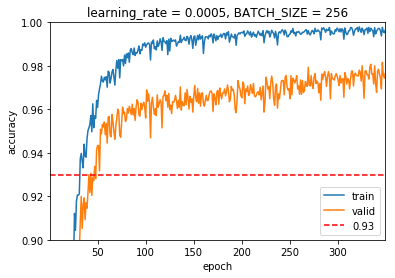

In [21]:
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline


print("Max Validation Accuracy by train data is {:.3f} ".format(np.max(accuracy_dict['train'])))
print("Average Validation Accuracy by train data is {:.3f} ".format(np.mean(accuracy_dict['train'][100:])))
print("\n")
print("Max Validation Accuracy by valid data is {:.3f} ".format(np.max(accuracy_dict['valid'])))
print("Average Validation Accuracy by valid data is {:.3f} ".format(np.mean(accuracy_dict['valid'][100:])))
print("\n")

# Show the result on graph
plt.xlabel("epoch")
epoch = np.arange(1, accuracy_dict['train'].shape[0]+1, 1)
plt.ylabel("accuracy")
#plt.axis([1,accuracy_dict['train'].shape[0], 0.9,1.0])
plt.axis([1,349, 0.9,1.0])
plt.title("learning_rate = "+str(learning_rate)+", BATCH_SIZE = "+str(BATCH_SIZE))

for data_type in ['train', 'valid'] :
    plt.plot(epoch,accuracy_dict[data_type], label=str(data_type))

clear_percentage = 0.93
plt.plot(epoch,np.full(i, clear_percentage, dtype=float),'r--', label=str(clear_percentage))
plt.legend()
plt.show()